In [1]:
!pip install --upgrade diffusers transformers -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cached-path 1.1.6 requires huggingface-hub<0.11.0,>=0.8.1, but you have huggingface-hub 0.12.1 which is incompatible.
allennlp 2.10.1 requires transformers<4.21,>=4.1, but you have transformers 4.26.1 which is incompatible.


In [2]:
from pathlib import Path
import tqdm

import torch
import pandas as pd
import numpy as np
from diffusers import StableDiffusionPipeline
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt

from kaggle_secrets import UserSecretsClient

In [3]:
class CFG:
    device = "cuda"
    seed = 30
    generator = torch.Generator(device).manual_seed(seed)
    image_gen_steps = 35
    image_gen_model_id = "stabilityai/stable-diffusion-2"
    image_gen_size = (512, 512)
    image_gen_guidance_scale = 9
    prompt_gen_model_id = "gpt2"
    prompt_dataset_size = 6
    prompt_max_length = 12

In [11]:
secret_hf_token = UserSecretsClient().get_secret("Kaggle")

In [19]:
image_gen_model = StableDiffusionPipeline.from_pretrained(
    CFG.image_gen_model_id, torch_dtype=torch.float16,
    revision="fp16", use_auth_token=secret_hf_token, guidance_scale=9
)
image_gen_model = image_gen_model.to(CFG.device)

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Keyword arguments {'guidance_scale': 9} are not expected by StableDiffusionPipeline and will be ignored.


In [20]:
prompts_gen_model = pipeline('text-generation', model='gpt2')

In [21]:
def generate_image(prompt, model):
    image = model(
        prompt, num_inference_steps=CFG.image_gen_steps,
        generator=CFG.generator,
        guidance_scale=CFG.image_gen_guidance_scale
    ).images[0]
    
    image = image.resize(CFG.image_gen_size)
    return image

  0%|          | 0/35 [00:00<?, ?it/s]

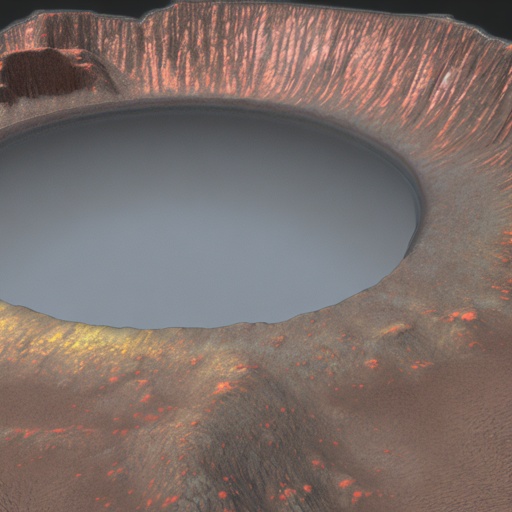

In [22]:
generate_image("hyper realistic photo of very friendly and dystopian crater", image_gen_model)

In [23]:
def generate_prompts(model, starting_phrase, max_length, num_return_sequences):
    set_seed(CFG.seed)
    prompts = model(
        starting_phrase, max_length=max_length,
        num_return_sequences=num_return_sequences
    )
    return [prompt["generated_text"] for prompt in prompts]

In [24]:
generated_prompts = generate_prompts(prompts_gen_model, "A picture of ", CFG.prompt_max_length, CFG.prompt_dataset_size)
generated_prompts

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['A picture of ʿAlhazred. His',
 'A picture of iphone 5x5 and iPhone 5',
 'A picture of ichor poisoning. Credit: A.',
 'A picture of \xa0Lepidoptera \xa0',
 'A picture of \xa0A new family tree!\xa0\n',
 'A picture of iced tea, a green tea, an']

In [25]:
def generate_images_by_prompts(prompts, model):
    return [generate_image(prompt, model) for prompt in prompts]

In [ ]:
%%time
generated_images = generate_images_by_prompts(generated_prompts, image_gen_model)

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
for image, prompt in zip(generated_images, generated_prompts):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(prompt, fontsize=14)
    plt.show()

In [ ]:
dataset_path = Path("/kaggle/working/dataset")
dataset_path.mkdir(parents=True, exist_ok=True)

images_path = Path(dataset_path / "images")
images_path.mkdir(parents=True, exist_ok=True)

In [ ]:
for idx, image in enumerate(generated_images):
    image.save(images_path / f"{str(idx).zfill(5)}.png")

In [ ]:
for img in images_path.iterdir():
    print(img)

In [ ]:
prompts_df = pd.DataFrame({"imgId": [str(idx).zfill(5) for idx in range(len(generated_prompts))], "prompt": generated_prompts})
prompts_df["imgId"] = prompts_df["imgId"].astype("str")
prompts_df

In [ ]:
prompts_df.to_csv(dataset_path / "prompts.csv", index=False)